In [10]:
import game
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

env = game.BlackJack()

In [11]:
def monte_carlo_control(env, num_episodes=500000, gamma=1.0, N0=100):

 # Initializing  Q(s,a) to zeros and state-action visit counts
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N_s = defaultdict(int)
    N_sa = defaultdict(lambda: np.zeros(env.action_space.n))
    
#staring a new episode and storing it 
    for episode in range(num_episodes):
        state = env.reset()
        episode_data = []
        done = False
# generate an episode using epsilon-greedy policy derived from Q      
        while not done:
            epsilon = N0 / (N0 + N_s[state])
            action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state]) # Epsilon-greedy action selection
            next_state, reward, done, _ = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state
            
# Calculating returns and update Q using First-Visit Monte Carlo   
        G = 0
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = gamma * G + reward
            N_s[state] += 1
            N_sa[state][action] += 1
            alpha = 1 / N_sa[state][action] 
            Q[state][action] += alpha * (G - Q[state][action])
            
# Return the learned Q-function    
    return Q

In [12]:
# intializing to learn the optimal action-value function Q using Monte Carlo Control
Q = monte_carlo_control(env)

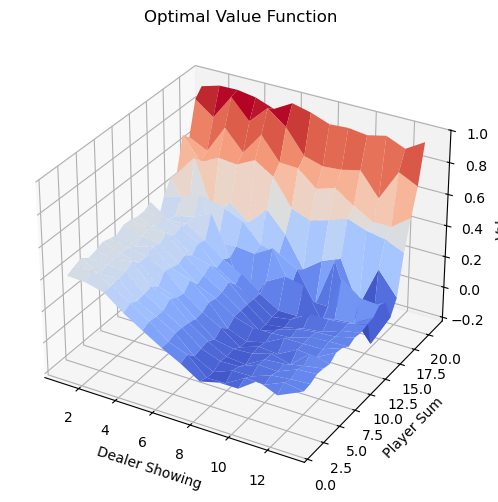

In [13]:
# Plot the state-value function V(s) from Q-values as a 3D surface
def plot_value_function(Q):
    
# Derive the state-value function V(s) by taking the max over actions in Q(s, a)
    V = {state: max(action_values) for state, action_values in Q.items()}
    dealer_values = sorted(set(state[0] for state in V))
    player_values = sorted(set(state[1] for state in V))
# Create a meshgrid for plotting
    X, Y = np.meshgrid(dealer_values, player_values)
    Z = np.zeros(X.shape)
    
# Fill the Z grid with state values V(s) 
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = V.get((X[i, j], Y[i, j]), 0)
            
 # Set up 3D plot and plot the plot value function surface and label axes and title
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='coolwarm')
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.set_title('Optimal Value Function')
    plt.show()
    
# Call the function to visualize the value function from Q
plot_value_function(Q)

In [14]:
def epsilon_greedy(Q, state, epsilon, nA):
    if state not in Q or np.random.rand() < epsilon:
        return np.random.randint(nA)
    return np.argmax(Q[state])
    
# SARSA(λ) forward-view algorithm to update Q-values
def sarsa_lambda_forward(env, lambda_, alpha=0.1, epsilon=0.1, num_episodes=1000, gamma=1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Initialize Q-table

# Stores (state, action, reward) for the episode
    for episode in range(num_episodes):
            episode_data = []
            state = env.reset()
            action = epsilon_greedy(Q, state, epsilon, env.action_space.n)
    
            done = False
            while not done:
                next_state, reward, done, _ = env.step(action)
                next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n) if not done else None
                episode_data.append((state, action, reward))
                state = next_state
                action = next_action
                
      # Total time steps in the episode
            T = len(episode_data)
        
      # Forward view SARSA(λ) return calculation and Q update
            for t in range(T):
                G = 0.0
                lambda_power = 1.0
                for n in range(1, T - t + 1): 
                    
      # Cumulative reward for n steps
                    g_n = sum((gamma ** k) * episode_data[t + k][2] for k in range(n))
                    if t + n < T:
                        s_next, a_next, _ = episode_data[t + n]
                        g_n += (gamma ** n) * Q[s_next][a_next]
                    G += lambda_power * g_n
                    lambda_power *= lambda_
        # Final λ-return including tail component
                G *= (1 - lambda_)
                G += (lambda_ ** (T - t)) * Q[episode_data[-1][0]][episode_data[-1][1]]
                s_t, a_t, _ = episode_data[t]
                Q[s_t][a_t] += alpha * (G - Q[s_t][a_t])
                
    # Return the learned Q-table
    return Q

In [15]:
# Compute the Mean Squared Error between estimated Q-values and true Q-values
def mean_squared_error(Q_estimate, Q_true):
    total_error = 0.0
    count = 0
    for state in Q_true:   
        for action in range(2):  # Assuming two possible actions: 0 and 1
            error = Q_estimate[state][action] - Q_true[state][action]
            total_error += error ** 2
            count += 1
    return total_error / count

# Run SARSA(λ) for multiple λ values and plot MSE compared to true Q-values
def run_mse_vs_lambda(env, Q_true, lambda_values):
    mse_list = []
    for lmbd in lambda_values:
        Q_lambda = sarsa_lambda_forward(env, lambda_=lmbd)
        mse = mean_squared_error(Q_lambda, Q_true)
        mse_list.append(mse)
        print(f"λ = {lmbd:.1f} -> MSE: {mse:.4f}")
        
# Plot λ vs MSE  
    plt.figure(figsize=(8, 5))
    plt.plot(lambda_values, mse_list, marker='o')
    plt.xlabel("λ")
    plt.ylabel("Mean Squared Error")
    plt.title("MSE between Sarsa(λ) and True Q-values")
    plt.grid(True)
    plt.show()

In [16]:
from collections import defaultdict
import numpy as np

# Run SARSA(λ) over multiple episodes and track the Mean Squared Error (MSE) per episode
def run_learning_curve(env, Q_true, lambda_, alpha=0.1, epsilon=0.1, gamma=1.0, episodes=1000):
    errors = [] # To store MSE at each episode
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #intializing Q table

    for ep in range(episodes):
# Storing (state, action, reward) transitions
        episode_data = []
        state = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)
        done = False

# Generate one episode
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n) if not done else None
            episode_data.append((state, action, reward))
            state = next_state
            action = next_action

        T = len(episode_data) # Episode length
    
 # If λ = 1.0, use Monte Carlo update
        if lambda_ == 1.0:
            G = 0.0
            for t in reversed(range(T)):
                s_t, a_t, r_t = episode_data[t]
                G = r_t + gamma * G
                Q[s_t][a_t] += alpha * (G - Q[s_t][a_t]) # Update Q-value
                
# Else use forward view SARSA(λ)
        else:
            for t in range(T):
                G = 0.0
                lambda_power = 1.0
                for n in range(1, T - t + 1):
 # Compute n-step return
                    g_n = sum((gamma ** k) * episode_data[t + k][2] for k in range(n))
                    if t + n < T:
                        s_next, a_next, _ = episode_data[t + n]
                        g_n += (gamma ** n) * Q[s_next][a_next]
                    G += lambda_power * g_n
                    lambda_power *= lambda_
 # Compute λ-return        
                G *= (1 - lambda_)
                s_last, a_last, _ = episode_data[-1]
                G += (lambda_ ** (T - t)) * Q[s_last][a_last]
                s_t, a_t, _ = episode_data[t]
                Q[s_t][a_t] += alpha * (G - Q[s_t][a_t])

 # # Calculate MSE after each episode for overlapping statesor actions with Q_true
        mse_list = []
        for state in Q_true:
            for action in range(env.action_space.n):
                q_estimated = Q[state][action] if state in Q else 0.0
                mse_list.append((q_estimated - Q_true[state][action]) ** 2)
        mse = np.mean(mse_list)
        errors.append(mse)
 # Return list of MSE values over episodes
    return errors

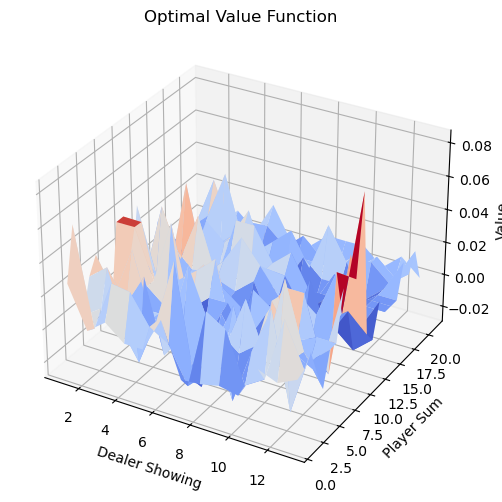

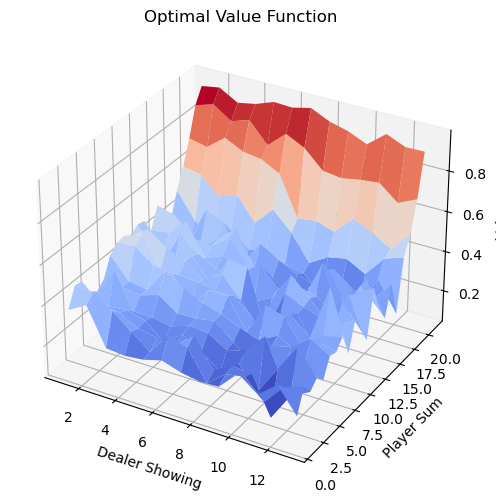

In [17]:
Q = sarsa_lambda_forward(env, lambda_=0.9)
Q_s = sarsa_lambda_forward(env, lambda_=0.9, num_episodes=500000)
plot_value_function(Q)
plot_value_function(Q_s)

λ = 0.0 -> MSE: 0.1119
λ = 0.1 -> MSE: 0.1106
λ = 0.2 -> MSE: 0.1125
λ = 0.3 -> MSE: 0.1117
λ = 0.4 -> MSE: 0.1135
λ = 0.5 -> MSE: 0.1188
λ = 0.6 -> MSE: 0.1180
λ = 0.7 -> MSE: 0.1197
λ = 0.8 -> MSE: 0.1225
λ = 0.9 -> MSE: 0.1243
λ = 1.0 -> MSE: 0.1276


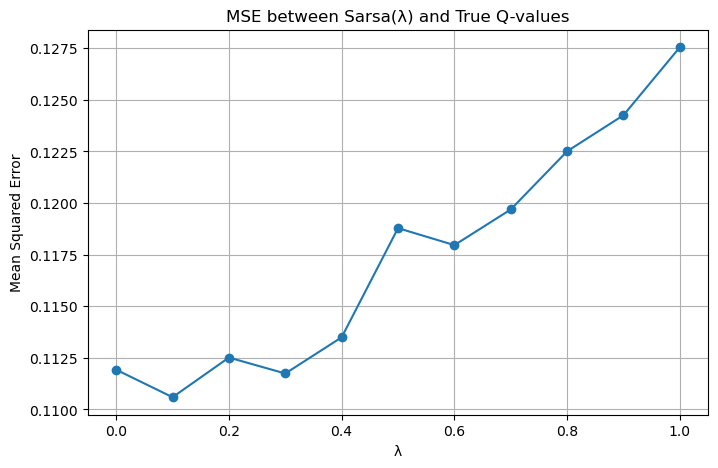

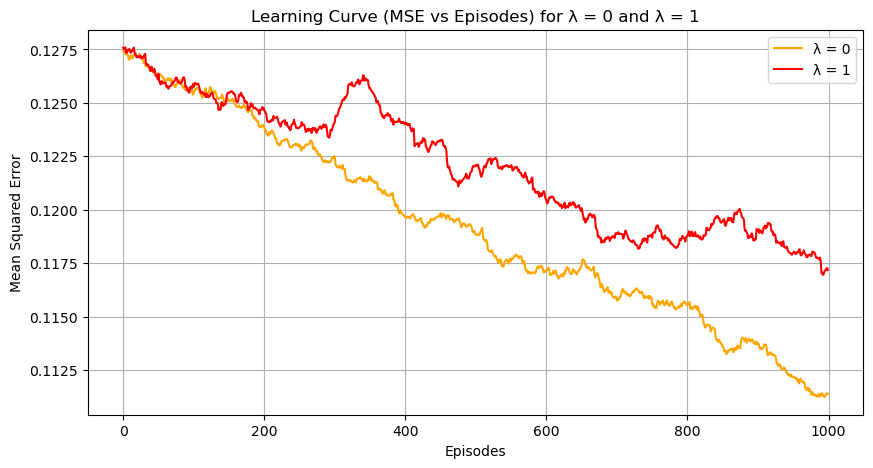

In [18]:
# estimate the true action-value function Q* using Monte Carlo control
Q_star = monte_carlo_control(env, num_episodes=500000)

# Define a list of lambda values and evaluate and plot MSE of SARSA(λ) for different λ values compared to Q*
lambda_vals = np.round(np.arange(0.0, 1.1, 0.1), 1)
run_mse_vs_lambda(env, Q_star, lambda_vals)

# Run learning curve for λ = 0 (pure TD(0)) and for λ = 1 (Monte Carlo)
lc_0 = run_learning_curve(env, Q_star, lambda_=0.0)
lc_1 = run_learning_curve(env, Q_star, lambda_=1.0)

# Plot the learning curves (MSE over episodes) for λ = 0 and λ = 1
plt.figure(figsize=(10, 5))
plt.plot(lc_0, label="λ = 0", color='orange')
plt.plot(lc_1, label="λ = 1", color='red')
plt.xlabel("Episodes")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve (MSE vs Episodes) for λ = 0 and λ = 1")
plt.legend()
plt.grid(True)
plt.show()